# Resistor Networks - Current Controlled

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve, cg
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
import itertools
import generate_adjacency_matrix as gen_adj
from __future__ import division

In this case, I would like to see how a current controlled network might change the phase transition we are observing.  To 

In [3]:
class ResistorNetwork(object):
    """
    This is a basic class for solving a resistor network.  Initializing the network requires:
    
        G                 - An NxN sparse CSR matrix containing the conductances in the network of N nodes
        external_voltages - An Nx1 dense vector of external voltages.  Nodes not set to an external voltages contain a Nan.
                            The shape (N,) is preferred

    Other available data attributes are:
    
        voltages          - These are the voltages of the internal nodes in the network.  They are initally set to None and
                            are filled in upon calling self.solve()
        nodes             - The number of nodes in the network
        interior          - The index of interior nodes not set to an external voltage
        boundary          - The index of boundary nodes set to an external voltage
    """
    
    def __init__(self, G, external_voltages):
        self.G = G
        self.external_voltages = external_voltages
        self.voltages = None
        self.nodes, tmp = self.G.shape
        self.interior, = np.isnan(self.external_voltages).nonzero()
        self.boundary, = np.logical_not(np.isnan(self.external_voltages)).nonzero()
        
        
    def solve_voltages(self, solver, V_0=None):
        """
        This method solves for the node voltages of the resistor network.  It also assumes the network is well
        defined, i.e. all nodes are part of a single connected component.  If this is not the case, run a
        connected component algorithm on it and feed in the percolating clusters individually. Current solvers are:
        
            'spsolve' - Scipy's exact sparse solver
            'cg'      - Scipy's sparse conjugate gradient solver. Note that conj grad seems to do well for solving a
                        network with separate components without breaking it up first but I'm not sure how safe this
                        is if we begin changing it's initial state.
        
        The second optional argument is
        
            V_0       - (optional) An initial guess for the voltages in the network for the conjugate gradient solver. I
                        think this may be useful for memristor networks where the current and previous voltages are only
                        infinitesimally separated.
        """
        
        # First we form the equations matrix.  To do this, we remove the rows and columns of boundary nodes,
        # trading our Neumann boundary conditions for Dirichlet
        L = self.graph_laplacian()
        D = L[self.interior, :][:, self.interior]
        # The columns corresponding to boundary nodes give a constant vector on the interior nodes yielding
        # the equation Dv = b (the -1 subtracts it to the other side of the equation)
        b = -1. * L[self.interior, :][:, self.boundary].dot(self.external_voltages[self.boundary])
        
        # Put our boundary values in for the voltages
        self.voltages = np.zeros_like(self.external_voltages)
        self.voltages[self.boundary] = self.external_voltages[self.boundary]
        
        # and solve!
        if solver == 'spsolve':
            self.voltages[self.interior] = spsolve(D, b)
        elif solver == 'cg':
            #I'd like to include an optional parameter to give the initial guess for the voltages in the network
            if V_0 == None:
                self.voltages[self.interior], convergence = cg(D, b)
            else:
                self.voltages[self.interior], convergence = cg(D, b, V_0[self.interior])
            #print "Conjugate Gradient converges with %d" % convergence
        else:
            print "Solver not specified.  Try 'spsolve' or 'cg'"
            
    
    def graph_laplacian(self):
        """
        Returns the graph laplacian for the resistor network.  This is L = D - G where D is the 'degree' matrix
        (for us a diagonal matrix of the sum of the incident conductances to each node) and G is the 'adjacency'
        matrix (for us the conductance matrix G)
        """
        # Note that for CSR matrices it is faster to sum across rows
        return sparse.dia_matrix((self.G.sum(1).flat, [0]), shape=(self.nodes,self.nodes)).tocsr() - self.G
    
    def power(self):
        """
        Returns a sparse matrix in CSR form containing the power dissipated between nodes i and j.  Requires that
        self.solve() have been called to populate self.voltages
        """
        # Pull nonzero values to iterate only over occupied bonds
        # as G is symmetric we can take only the upper trianglular part
        rows, cols = sparse.triu(self.G).nonzero()
        
        # Fill in the entries in the power matrix
        power = sparse.lil_matrix(self.G.shape)
        for node_i, node_j in itertools.izip(rows, cols):
            power[node_i, node_j] = self.G[node_i, node_j] * (self.voltages[node_i] - self.voltages[node_j])**2
            power[node_j, node_i] = power[node_i, node_j]
        return power.tocsr()
    
    def voltage_drop(self):
        """
        Return a sparse matrix in CSR form containing the voltage drop between nodes i and j.  Requires that self.solve()
        have been called to populate self.voltages
        """
        rows, cols = sparse.triu(self.G).nonzero()
        
        # fill in the entries in the voltage drop matrix
        voltage_drop = sparse.lil_matrix(self.G.shape)
        for node_i, node_j in itertools.izip(rows, cols):
            voltage_drop[node_i, node_j] = self.voltages[node_j] - self.voltages[node_i]
            voltage_drop[node_j, node_i] = -1 * voltage_drop[node_i, node_j]
        return voltage_drop.tocsr()
    
    def voltage_drop_abs(self):
        """
        Return a sparse matrix in CSR form containing the voltage drop between nodes i and j.  Requires that self.solve()
        have been called to populate self.voltages
        """
        rows, cols = sparse.triu(self.G).nonzero()
        
        # fill in the entries in the voltage drop matrix
        voltage_drop = sparse.lil_matrix(self.G.shape)
        for node_i, node_j in itertools.izip(rows, cols):
            voltage_drop[node_i, node_j] = abs(self.voltages[node_j] - self.voltages[node_i])
            voltage_drop[node_j, node_i] = voltage_drop[node_i, node_j]
        return voltage_drop.tocsr()
        
    def external_current(self):
        """
        Returns the currents entering the nodes on the boundary.  These are calculated from,
        
        graph_laplacian[boundary,:].dot(self.voltages)
        
        and thus occur in the order specified by self.boundary
        """
        return self.graph_laplacian()[self.boundary, :].dot(self.voltages)
    
    def conductivity(self):
        """
        The total conductivity of the network is calculated as the sum of the positive external currents divided
        by the voltage difference across the network.  In order for this to work, 
        """
        I_external = self.external_current()
        return I_external[I_external > 0].sum() / (np.nanmax(self.external_voltages) - np.nanmin(self.external_voltages))
    
    def display_ring(self, ax, display_variable, nodesize=5, bondwidth=2, colormin=None, colormax=None):
        """
        This method displays a  resistor network of N nodes on the unit circle with resistors displayed as bonds between the
        nodes.  Indexing begins with the node at the 3 o'clock position and procedes counter clockwise around the circle.
        The variables that may be displayed are:
        
            'voltage'
            'power'
            'conductance'
            'voltage_drop'
            'log_voltage_drop'
            
        """ 
        
        delta_theta = 2 * np.pi / self.nodes
        
        def node2xy_circle(node_idx):
            """
            returns the x and y coordinates of a node index on the unit circle assuming that the 0 node is 
            """
            complex_coord = np.exp(node_idx * delta_theta * 1j)
            return complex_coord.real, complex_coord.imag
        
        # Pull nonzero values to plot bonds
        rows, cols = sparse.triu(self.G).nonzero()
        
        
        # Set up colormap normalization
        
        if colormin != None:
            norm = plt.Normalize(vmin=colormin, vmax=colormax)
        elif display_variable == 'voltage':
            norm = plt.Normalize()
            norm.autoscale(self.voltages)
        elif display_variable == 'power':
            power = self.power()
            norm = plt.Normalize(vmin=power.min(), vmax=power.max())
        elif display_variable == 'conductance':
            conductances = self.G[rows, cols]
            norm = plt.Normalize(vmin=conductances.min(), vmax=conductances.max())
        elif display_variable == 'voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=0, vmax=voltage_drop.max())
        elif display_variable == 'log_voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=np.log(voltage_drop.data.min()),
                                 vmax=np.log(voltage_drop.max()))
        
        if display_variable == 'voltage':
            colormap = plt.get_cmap('Reds')
        elif display_variable == 'power':
            colormap = plt.get_cmap('YlOrRd')
        elif display_variable == 'conductance':
            colormap = plt.get_cmap('Greys')
        elif display_variable == 'voltage_drop':
            colormap = plt.get_cmap('jet')
        elif display_variable == 'log_voltage_drop':
            colormap = plt.get_cmap('jet')
        else:
            print 'Invalid display variable %s' % display_variable
        
        
            
        # Draw the bonds between nodes
        for node_i, node_j in itertools.izip(rows, cols):
            x_i, y_i = node2xy_circle(node_i)
            x_j, y_j = node2xy_circle(node_j)
            if display_variable == 'voltage':
                ax.plot([x_i, x_j], [y_i, y_j], 'k', lw = bondwidth)
            elif display_variable == 'power':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(power[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'conductance':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(self.G[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(voltage_drop[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'log_voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(np.log(voltage_drop[node_i, node_j]))), lw=bondwidth)
        
        # Now draw the nodes
        if display_variable == 'voltage':
            for node, volt in enumerate(self.voltages):
                x, y = node2xy_circle(node)
                ax.plot(x, y, 'o', markersize=nodesize, color=colormap(norm(volt)))
        elif display_variable == 'power' or 'conductance' or 'voltage_drop' or 'log_voltage_drop':
            for node in range(self.nodes):
                x, y = node2xy_circle(node)
                ax.plot(x, y, 'wo', markersize=nodesize)
        
        # And finally set the axes to be just outside the grid spacing and invert the y_axis
        ax.set_xlim( -1.1, 1.1)
        ax.set_ylim( -1.1, 1.1)
        
    def display_grid(self, ax, lattice_shape, display_variable, nodesize=5, bondwidth=3, colormin=None, colormax=None,
                     colormap_name=None):
        """
        This method displays a 2D cubic resistor lattice of shape lattice_shape = (y, x).  The variables
        that may be displayed are:
        
            'voltage'
            'power'
            'conductance'
            'log-power'
            
        Nodes are indexed across rows such that the first row has nodes 0 through x-1.  This is because I typically
        like to set up networks with a vertical bus bar architecture and it makes setting the nodes as simple as possible.
        """ 
        def node2xy(node_idx):
            """
            returns the x and y coordinates of a node index in our grid supposing that the 0,0 point is in the upper left
            and the positive y-axis points down
            """
            return node_idx % lattice_shape[1], int(node_idx / lattice_shape[1]) 
        
        # Pull nonzero values to plot bonds
        rows, cols = sparse.triu(self.G).nonzero()
        
        
        # Set up colormap normalization
        
        if colormin != None:
            norm = plt.Normalize(vmin=colormin, vmax=colormax)
        elif display_variable == 'voltage':
            norm = plt.Normalize()
            norm.autoscale(self.voltages)
        elif display_variable == 'power':
            power = self.power()
            norm = plt.Normalize(vmin=power.min(), vmax=power.max())
        elif display_variable == 'conductance':
            conductances = self.G[rows, cols]
            norm = plt.Normalize(vmin=conductances.min(), vmax=conductances.max())
        elif display_variable == 'voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=0, vmax=voltage_drop.max())
        elif display_variable == 'log_voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=np.log(voltage_drop.data.min()),
                                 vmax=np.log(voltage_drop.max()))
        
        if colormap_name != None:
            colormap = plt.get_cmap(colormap_name)
        else:
            if display_variable == 'voltage':
                colormap = plt.get_cmap('Reds')
            elif display_variable == 'power':
                colormap = plt.get_cmap('YlOrRd')
            elif display_variable == 'conductance':
                colormap = plt.get_cmap('Greys')
            elif display_variable == 'voltage_drop':
                colormap = plt.get_cmap('jet')
            elif display_variable == 'log_voltage_drop':
                colormap = plt.get_cmap('jet')
        
        
            
        # Draw the bonds between nodes
        for node_i, node_j in itertools.izip(rows, cols):
            x_i, y_i = node2xy(node_i)
            x_j, y_j = node2xy(node_j)
            if display_variable == 'voltage':
                ax.plot([x_i, x_j], [y_i, y_j], 'k', lw = bondwidth)
            elif display_variable == 'power':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(power[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'conductance':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(self.G[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(voltage_drop[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'log_voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(np.log(voltage_drop[node_i, node_j]))), lw=bondwidth)
        
        # Now draw the nodes
        if display_variable == 'voltage':
            for node, volt in enumerate(self.voltages):
                x, y = node2xy(node)
                ax.plot(x, y, 's', markersize=nodesize, color=colormap(norm(volt)))
        elif display_variable == 'power' or 'conductance' or 'voltage_drop' or 'log_voltage_drop':
            for node in range(self.nodes):
                x, y = node2xy(node)
                ax.plot(x, y, 'ws', markersize=nodesize)
        
        # And finally set the axes to be just outside the grid spacing and invert the y_axis
        ax.set_xlim( -1, lattice_shape[1])
        ax.set_ylim( -1, lattice_shape[0])
        ax.invert_yaxis()
        ax.xaxis.set_tick_params(labelbottom='off', labeltop='on')
        
    def display_diag_grid(self, ax, lattice_shape, display_variable, nodesize=5, bondwidth=3, colormin=None, colormax=None,
                     colormap_name=None):
        
        def node2xy(node_idx):
            """
            returns the x and y coordinates of a node index in our grid supposing that the 0,0 point is in the upper left
            and the positive y-axis points down
            """
            col_index = node_idx % lattice_shape[1]
            row_index = node_idx // lattice_shape[1]
            row_parity = row_index % 2
            
            return col_index + (0.5 * row_parity), 0.5 * row_index
        
        
        # Pull nonzero values to plot bonds
        rows, cols = sparse.triu(self.G).nonzero()
        
        
        # Set up colormap normalization
        
        if colormin != None:
            norm = plt.Normalize(vmin=colormin, vmax=colormax)
        elif display_variable == 'voltage':
            norm = plt.Normalize()
            norm.autoscale(self.voltages)
        elif display_variable == 'power':
            power = self.power()
            norm = plt.Normalize(vmin=power.min(), vmax=power.max())
        elif display_variable == 'conductance':
            conductances = self.G[rows, cols]
            norm = plt.Normalize(vmin=conductances.min(), vmax=conductances.max())
        elif display_variable == 'voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=0, vmax=voltage_drop.max())
        elif display_variable == 'log_voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=np.log(voltage_drop.data.min()),
                                 vmax=np.log(voltage_drop.max()))
        
        if colormap_name != None:
            colormap = plt.get_cmap(colormap_name)
        else:
            if display_variable == 'voltage':
                colormap = plt.get_cmap('Reds')
            elif display_variable == 'power':
                colormap = plt.get_cmap('YlOrRd')
            elif display_variable == 'conductance':
                colormap = plt.get_cmap('Greys')
            elif display_variable == 'voltage_drop':
                colormap = plt.get_cmap('jet')
            elif display_variable == 'log_voltage_drop':
                colormap = plt.get_cmap('jet')
        
        # Draw the bonds between nodes
        for node_i, node_j in itertools.izip(rows, cols):
            x_i, y_i = node2xy(node_i)
            x_j, y_j = node2xy(node_j)
            #Check for our wrap around nodes
            if node_j - node_i == 2*lattice_shape[1] - 1:
                x_i = x_i + lattice_shape[1]
            elif node_j - node_i == 1:
                x_j = x_j + lattice_shape[1]
            
            if display_variable == 'voltage':
                ax.plot([x_i, x_j], [y_i, y_j], 'k', lw = bondwidth)
            elif display_variable == 'power':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(power[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'conductance':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(self.G[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(voltage_drop[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'log_voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(np.log(voltage_drop[node_i, node_j]))), lw=bondwidth)
                
        # Now draw the nodes
        if display_variable == 'voltage':
            for node, volt in enumerate(self.voltages):
                x, y = node2xy(node)
                ax.plot(x, y, 's', markersize=nodesize, color=colormap(norm(volt)))
        elif display_variable == 'power' or 'conductance' or 'voltage_drop' or 'log_voltage_drop':
            for node in range(self.nodes):
                x, y = node2xy(node)
                ax.plot(x, y, 'ws', markersize=nodesize)
        
        # And finally set the axes to be just outside the grid spacing and invert the y_axis
        ax.set_xlim( -1, lattice_shape[1]+1)
        ax.set_ylim( -1, 0.5 * (lattice_shape[0]+1))
        ax.invert_yaxis()
        ax.xaxis.set_tick_params(labelbottom='off', labeltop='on')

#### Example Usage

In [4]:
# Create some initial parameters to use
num_nodes = 50
G = gen_adj.random_graph(num_nodes, 0.25, undirected=True)
v_external = np.empty(num_nodes) * np.nan
v_external[0:2] = 1
v_external[-2:] = 0

In [5]:
Rnet = ResistorNetwork(G, v_external)
L = Rnet.graph_laplacian()

In [6]:
%%timeit
Rnet.solve_voltages('cg')

100 loops, best of 3: 2.16 ms per loop


In [7]:
voltages_cg = Rnet.voltages

In [8]:
%%timeit
Rnet.solve_voltages('spsolve')

The slowest run took 4.02 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 1.78 ms per loop


In [9]:
np.allclose(voltages_cg, Rnet.voltages)

True

Testing the external current,

In [10]:
ext_current = Rnet.external_current()
ext_current

array([ 3.86732104,  5.61200713, -5.3080175 , -4.17131067])

These should sum to zero (or close to it)

In [11]:
np.isclose(ext_current.sum(), 0)

True

It is worth noting that conjugate gradient will introduce errors here on the order of $10^{-4}A$

The conductivity is the sum of the positive external currents divided by the voltage difference across the device.

In [12]:
Rnet.conductivity()

9.4793281671205527

Finally, we try displaying the network

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:218: RuntimeWarning: divide by zero encountered in log


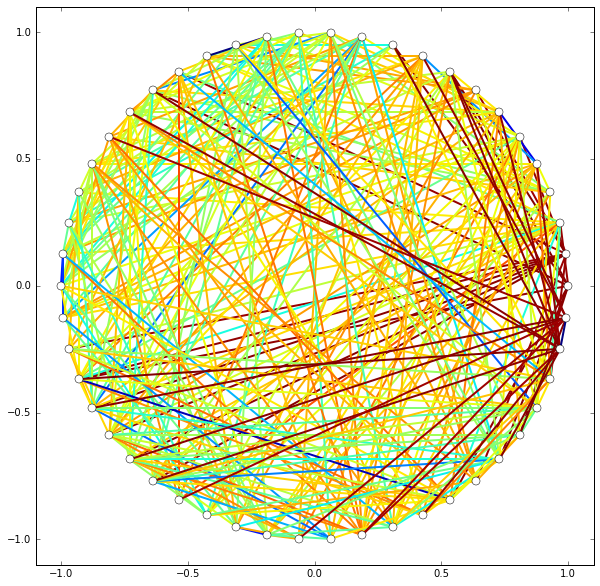

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
Rnet.display_ring(ax, 'log_voltage_drop', nodesize=8)

### Testing Diagonal Grid Display

In [14]:

G = gen_adj.cubic_2d_diagonal_periodic((21, 10))

v_external = np.empty(11*10) * np.nan
v_external[0:10] = 1
v_external[-10:] = 0

Rnet = ResistorNetwork(G, v_external)

In [15]:
Rnet.solve_voltages('spsolve')

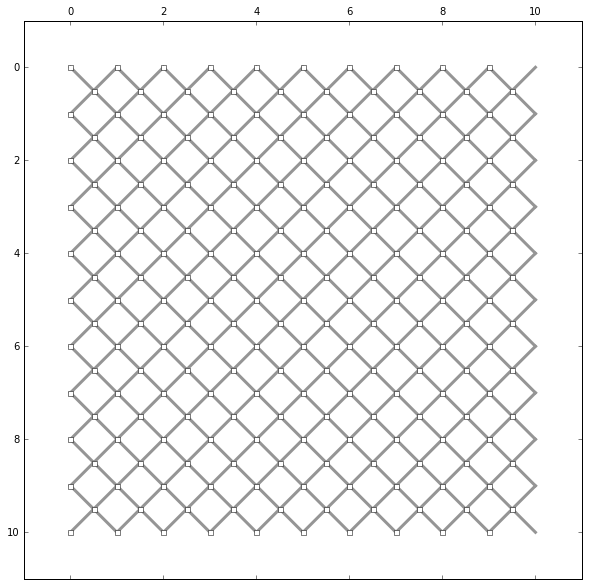

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
Rnet.display_diag_grid(ax, (21,10), 'conductance', colormin=0, colormax=2)


### Resistor Connected Component Solver

This class first breaks a network defined by a conductance matrix into a set of connected components and then
calls the resistor_network class on each component that needs to be solved.

In [271]:
class ResistorNetworkCC(object):
    """
    This class solves resistor network by first breaking the network into connected components and then solving each component
    separately.  Aside from this fact, it works by using composition with resistor_network.  Initializing a network requires:
    
        G                 - An NxN sparse CSR matrix containing the conductances in the network of N nodes
        external_voltages - An Nx1 dense vector of external voltages.  Nodes not set to an external voltages contain a Nan.
                            The shape (N,) is preferred

    Other available data attributes are:
    
        voltages          - These are the voltages of the internal nodes in the network.  They are initally set to None and
                            are filled in upon calling self.solve()
        nodes             - The number of nodes in the network
        num_comp          - The number of components in the undirected network as given by the connected_components function
                            in scipy.sparse.csgraph
        comp_labels       - An array containing the component of each node in the network from 
        interior          - The index of interior nodes not set to an external voltage
        boundary          - The index of boundary nodes set to an external voltage
    """
    
    def __init__(self, G, external_voltages):
        self.G = G
        self.external_voltages = external_voltages
        self.voltages = None
        self.nodes, tmp = self.G.shape
        self.num_comp, self.comp_labels = connected_components(self.G, directed=False)
        self.interior, = np.isnan(self.external_voltages).nonzero()
        self.boundary, = np.logical_not(np.isnan(self.external_voltages)).nonzero()
        
    def solve_voltages(self, solver, V_0=None):
        """
        This method solves for the node voltages of the resistor network by first breaking the network into connected
        components and then defining a resistor_network object for each percolating component. Current solvers are:
        
            'spsolve' - Scipy's exact sparse solver
            'cg'      - Scipy's sparse conjugate gradient solver.
        
        The second optional argument is
        
            V_0       - (optional) An initial guess for the voltages in the network for the conjugate gradient solver. I
                        think this may be useful for memristor networks where the current and previous voltages are only
                        infinitesimally separated.
        """
        
        self.voltages = np.zeros_like(self.external_voltages)
        
        # For each connected component
        for cc in range(self.num_comp):
            
            # Pull a boolean array of the node indices and use that to get the external voltages
            cc_nodes = (self.comp_labels == cc)
            cc_external_voltages = self.external_voltages[cc_nodes]
        
            # Find the maximum and minimum voltages on the component.  Nan's will only be found if no other number
            # is in the array
            cc_max = np.nanmax(cc_external_voltages)
            cc_min = np.nanmin(cc_external_voltages)
        
            # If the component is not set to any voltage, set it to zero
            if np.isnan(cc_max):
                self.voltages[cc_nodes] = 0
        
            # If it is set to a single external voltage, set all nodes to that value
            elif cc_max == cc_min:
                self.voltages[cc_nodes] = cc_max
        
            # Otherwise, it must be set to two external voltages, in which case we must solve it
            else:
                # Solve a percolating component over the limited conductance matrix and external voltage
                CC_RNet = ResistorNetwork(self.G[cc_nodes, :][:, cc_nodes], cc_external_voltages)
                if V_0 == None:
                    CC_RNet.solve_voltages(solver)
                else:
                    CC_RNet.solve_voltages(solver, V_0[cc_nodes])
                self.voltages[cc_nodes] = CC_RNet.voltages
    
    def graph_laplacian(self):
        """
        Returns the graph laplacian for the resistor network.  This is L = D - G where D is the 'degree' matrix
        (for us a diagonal matrix of the sum of the incident conductances to each node) and G is the 'adjacency'
        matrix (for us the conductance matrix G)
        """
        # Note that for CSR matrices it is faster to sum across rows
        return sparse.dia_matrix((self.G.sum(1).flat, [0]), shape=(self.nodes,self.nodes)).tocsr() - self.G
    
    def power(self):
        """
        Returns a sparse matrix in CSR form containing the power dissipated between nodes i and j.  Requires that
        self.solve() have been called to populate self.voltages
        """
        # Pull nonzero values to iterate only over occupied bonds
        # as G is symmetric we can take only the upper trianglular part
        rows, cols = sparse.triu(self.G).nonzero()
    
        # Fill in the entries in the power matrix
        power = sparse.lil_matrix(self.G.shape)
        for node_i, node_j in itertools.izip(rows, cols):
            power[node_i, node_j] = self.G[node_i, node_j] * (self.voltages[node_i] - self.voltages[node_j])**2
            power[node_j, node_i] = power[node_i, node_j]
        return power.tocsr()
    
    def voltage_drop(self):
        """
        Return a sparse matrix in CSR form containing the voltage drop between nodes i and j.  Requires that self.solve()
        have been called to populate self.voltages
        """
        rows, cols = sparse.triu(self.G).nonzero()
        
        # fill in the entries in the voltage drop matrix
        voltage_drop = sparse.lil_matrix(self.G.shape)
        for node_i, node_j in itertools.izip(rows, cols):
            voltage_drop[node_i, node_j] = self.voltages[node_j] - self.voltages[node_i]
            voltage_drop[node_j, node_i] = -1 * voltage_drop[node_i, node_j]
        return voltage_drop.tocsr()
    
    def voltage_drop_abs(self):
        """
        Return a sparse matrix in CSR form containing the voltage drop between nodes i and j.  Requires that self.solve()
        have been called to populate self.voltages
        """
        rows, cols = sparse.triu(self.G).nonzero()
        
        # fill in the entries in the voltage drop matrix
        voltage_drop = sparse.lil_matrix(self.G.shape)
        for node_i, node_j in itertools.izip(rows, cols):
            voltage_drop[node_i, node_j] = abs(self.voltages[node_j] - self.voltages[node_i])
            voltage_drop[node_j, node_i] = voltage_drop[node_i, node_j]
        return voltage_drop.tocsr()
     
    def external_current(self):
        """
        Returns the currents entering the nodes on the boundary.  These are calculated from,
        
        graph_laplacian[boundary,:].dot(self.voltages)
        
        and thus occur in the order specified by self.boundary
        """
        return self.graph_laplacian()[self.boundary, :].dot(self.voltages)
    
    def conductivity(self):
        """
        The total conductivity of the network is calculated as the sum of the positive external currents divided
        by the voltage difference across the network.  In order for this to work, there must be some voltage across
        the network.
        """
        I_external = self.external_current()
        return I_external[I_external > 0].sum() / (np.nanmax(self.external_voltages) - np.nanmin(self.external_voltages))
    
    def display_ring(self, ax, display_variable, nodesize=5, bondwidth=2, colormin=None, colormax=None):
        """
        This method displays a  resistor network of N nodes on the unit circle with resistors displayed as bonds between the
        nodes.  Indexing begins with the node at the 3 o'clock position and procedes counter clockwise around the circle.
        The variables that may be displayed are:
        
            'voltage'
            'power'
            'conductance'
            
        """ 
        
        delta_theta = 2 * np.pi / self.nodes
        
        def node2xy_circle(node_idx):
            """
            returns the x and y coordinates of a node index on the unit circle assuming that the 0 node is 
            """
            complex_coord = np.exp(node_idx * delta_theta * 1j)
            return complex_coord.real, complex_coord.imag
        
        # Pull nonzero values to plot bonds
        rows, cols = sparse.triu(self.G).nonzero()
        
        
        # Set up colormap normalization
        
        if colormin != None:
            norm = plt.Normalize(vmin=colormin, vmax=colormax)
        elif display_variable == 'voltage':
            norm = plt.Normalize()
            norm.autoscale(self.voltages)
        elif display_variable == 'power':
            power = self.power()
            norm = plt.Normalize(vmin=power.min(), vmax=power.max())
        elif display_variable == 'conductance':
            conductances = self.G[rows, cols]
            norm = plt.Normalize(vmin=conductances.min(), vmax=conductances.max())
        elif display_variable == 'voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=0, vmax=voltage_drop.max())
        elif display_variable == 'log_voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=np.log(voltage_drop.data.min()),
                                 vmax=np.log(voltage_drop.max()))
            
            
        if display_variable == 'voltage':
            colormap = plt.get_cmap('Reds')
        elif display_variable == 'power':
            colormap = plt.get_cmap('YlOrRd')
        elif display_variable == 'conductance':
            colormap = plt.get_cmap('Greys')
        elif display_variable == 'voltage_drop':
            colormap = plt.get_cmap('jet')
        elif display_variable == 'log_voltage_drop':
            colormap = plt.get_cmap('jet')
        else:
            print 'Invalid display variable %s' % display_variable
        
        
            
        # Draw the bonds between nodes
        for node_i, node_j in itertools.izip(rows, cols):
            x_i, y_i = node2xy_circle(node_i)
            x_j, y_j = node2xy_circle(node_j)
            if display_variable == 'voltage':
                ax.plot([x_i, x_j], [y_i, y_j], 'k', lw = bondwidth)
            elif display_variable == 'power':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(power[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'conductance':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(self.G[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(voltage_drop[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'log_voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(np.log(voltage_drop[node_i, node_j]))), lw=bondwidth)
                
        # Now draw the nodes
        if display_variable == 'voltage':
            for node, volt in enumerate(self.voltages):
                x, y = node2xy_circle(node)
                ax.plot(x, y, 'o', markersize=nodesize, color=colormap(norm(volt)))
        elif display_variable == 'power' or 'conductance' or 'voltage_drop' or 'log_voltage_drop':
            for node in range(self.nodes):
                x, y = node2xy_circle(node)
                ax.plot(x, y, 'wo', markersize=nodesize)
        
        # And finally set the axes to be just outside the grid spacing and invert the y_axis
        ax.set_xlim( -1.1, 1.1)
        ax.set_ylim( -1.1, 1.1)
        
    def display_grid(self, ax, lattice_shape, display_variable, nodesize=5, bondwidth=3, colormin=None, colormax=None,
                     colormap_name=None):
        """
        This method displays a 2D cubic resistor lattice of shape lattice_shape = (y, x).  The variables
        that may be displayed are:
        
            'voltage'
            'power'
            'conductance'
            
        Nodes are indexed across rows such that the first row has nodes 0 through x-1.  This is because I typically
        like to set up networks with a vertical bus bar architecture and it makes setting the nodes as simple as possible.
        """ 
        def node2xy(node_idx):
            """
            returns the x and y coordinates of a node index in our grid supposing that the 0,0 point is in the upper left
            and the positive y-axis points down
            """
            return node_idx % lattice_shape[1], int(node_idx / lattice_shape[1]) 
        
        # Pull nonzero values to plot bonds
        rows, cols = sparse.triu(self.G).nonzero()
        
        
        # Set up colormap normalization
        
        if colormin != None:
            norm = plt.Normalize(vmin=colormin, vmax=colormax)
        elif display_variable == 'voltage':
            norm = plt.Normalize()
            norm.autoscale(self.voltages)
        elif display_variable == 'power':
            power = self.power()
            norm = plt.Normalize(vmin=power.min(), vmax=power.max())
        elif display_variable == 'conductance':
            conductances = self.G[rows, cols]
            norm = plt.Normalize(vmin=conductances.min(), vmax=conductances.max())
        elif display_variable == 'voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=0, vmax=voltage_drop.max())
        elif display_variable == 'log_voltage_drop':
            voltage_drop = self.voltage_drop_abs()
            norm = plt.Normalize(vmin=np.log(voltage_drop.data.min()),
                                 vmax=np.log(voltage_drop.max()))
        
        if colormap_name != None:
            colormap = plt.get_cmap(colormap_name)
        else:
            if display_variable == 'voltage':
                colormap = plt.get_cmap('Reds')
            elif display_variable == 'power':
                colormap = plt.get_cmap('YlOrRd')
            elif display_variable == 'conductance':
                colormap = plt.get_cmap('Greys')
            elif display_variable == 'voltage_drop':
                colormap = plt.get_cmap('jet')
            elif display_variable == 'log_voltage_drop':
                colormap = plt.get_cmap('jet')
        
        
            
        # Draw the bonds between nodes
        for node_i, node_j in itertools.izip(rows, cols):
            x_i, y_i = node2xy(node_i)
            x_j, y_j = node2xy(node_j)
            if display_variable == 'voltage':
                ax.plot([x_i, x_j], [y_i, y_j], 'k', lw = bondwidth)
            elif display_variable == 'power':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(power[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'conductance':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(self.G[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(voltage_drop[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'log_voltage_drop':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(np.log(voltage_drop[node_i, node_j]))), lw=bondwidth)
        
        # Now draw the nodes
        if display_variable == 'voltage':
            for node, volt in enumerate(self.voltages):
                x, y = node2xy(node)
                ax.plot(x, y, 's', markersize=nodesize, color=colormap(norm(volt)))
        elif display_variable == 'power' or 'conductance' or  'voltage_drop' or 'log_voltage_drop':
            for node in range(self.nodes):
                x, y = node2xy(node)
                ax.plot(x, y, 'ws', markersize=nodesize)
        
        # And finally set the axes to be just outside the grid spacing and invert the y_axis
        ax.set_xlim( -1, lattice_shape[1])
        ax.set_ylim( -1, lattice_shape[0])
        ax.invert_yaxis()
        ax.xaxis.set_tick_params(labelbottom='off', labeltop='on')

#### Example Usage

In order to test this properly, I would need a network that actually breaks into separate components. First, I'd like to make sure it reproduces our last results.

In [272]:
Rnet = ResistorNetworkCC(G, v_external)
Rnet.num_comp

1

In [273]:
Rnet.solve_voltages('spsolve')
np.allclose(Rnet.voltages, voltages_cg)

True

In [274]:
%%timeit
Rnet = ResistorNetworkCC(G, v_external)
Rnet.solve_voltages('cg')

100 loops, best of 3: 3.78 ms per loop


In [275]:
%%timeit
Rnet = ResistorNetwork(G, v_external)
Rnet.solve_voltages('cg')

100 loops, best of 3: 2.71 ms per loop


In [276]:
Rnet.conductivity()

10.139410729076488

In [277]:
num_nodes=50
G = gen_adj.random_graph(num_nodes, 0.05, undirected=True)
v_external = np.empty(num_nodes) * np.nan
v_external[0:10] = 1
v_external[-10:] = 0
Rnet = ResistorNetworkCC(G, v_external)
Rnet.num_comp

4

In [278]:
Rnet = ResistorNetworkCC(G, v_external)
Rnet.solve_voltages('spsolve')
spsolve_voltages_cc = Rnet.voltages

In [279]:
Rnet.solve_voltages('cg')
np.allclose(spsolve_voltages_cc, Rnet.voltages, rtol=1e-3)

True

If we instead tried to solve this network with resistor_network

In [280]:
Rnet = ResistorNetwork(G, v_external)
Rnet.solve_voltages('spsolve')
np.allclose(spsolve_voltages_cc, Rnet.voltages, rtol=1e-1)

False

Disaster..., but with conjugate gradient

In [281]:
Rnet = ResistorNetwork(G, v_external)
Rnet.solve_voltages('cg')
np.allclose(spsolve_voltages_cc, Rnet.voltages, rtol=1e-3)

True

In [282]:
Rnet.conductivity()

12.733096427645446

It seems to work, but as I said before, I'm not sure this is safe as it probably depends on the inital point chosen by the cg
solver (which I believe is $\vec{0}$). Hence it works if I start all the disconnected components to 0 but they are probably stationary if I set them to anything else. To check,

In [283]:
Rnet = ResistorNetwork(G, v_external)
Rnet.solve_voltages('cg', V_0=np.ones_like(v_external))
np.allclose(spsolve_voltages_cc, Rnet.voltages, rtol=1e-1)

False

And lastly, displaying

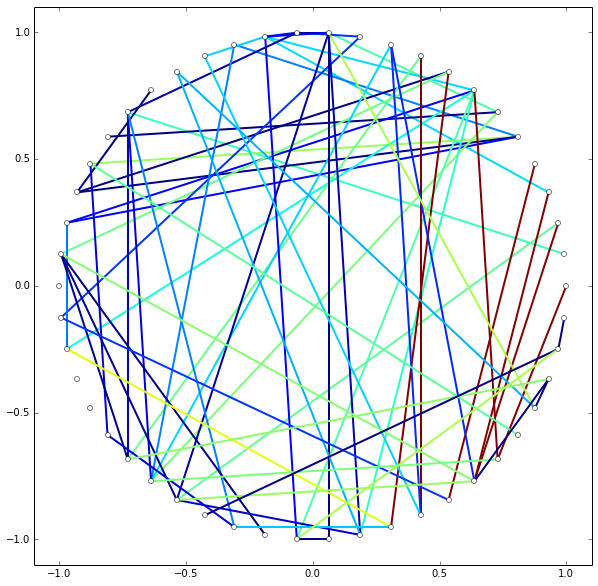

In [284]:
fig, ax = plt.subplots(figsize=(10,10))
Rnet.display_ring(ax, 'voltage_drop')

In [285]:
G = gen_adj.cubic_2d((20, 20))
v_external = np.empty(20*20)*np.nan
v_external[0:20] = 1
v_external[-20:] = 0

In [286]:
Rlattice = ResistorNetwork(G, v_external)

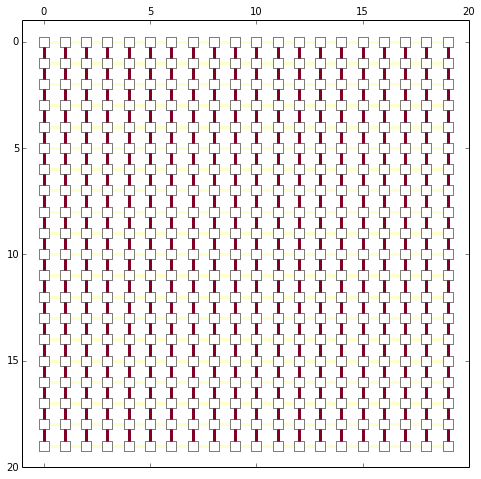

In [287]:
fig, ax = plt.subplots(figsize=(8,8))
Rlattice.solve_voltages('cg')
Rlattice.display_grid(ax, (20, 20), 'power', nodesize=10)

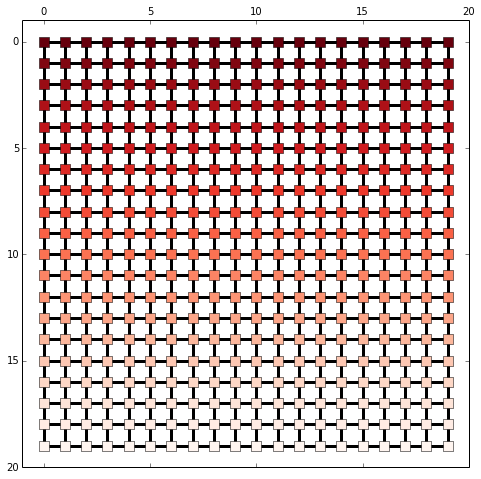

In [288]:
fig, ax = plt.subplots(figsize=(8,8))
Rlattice.display_grid(ax, (20, 20), 'voltage', nodesize=10)

In [293]:
L = 128
G = gen_adj.cubic_2d_random((L, L), 0.5)
v_external = np.empty(L*L) * np.nan
v_external[0:L] = 1
v_external[-1*L:] = 0
Rnet = ResistorNetworkCC(G, v_external)

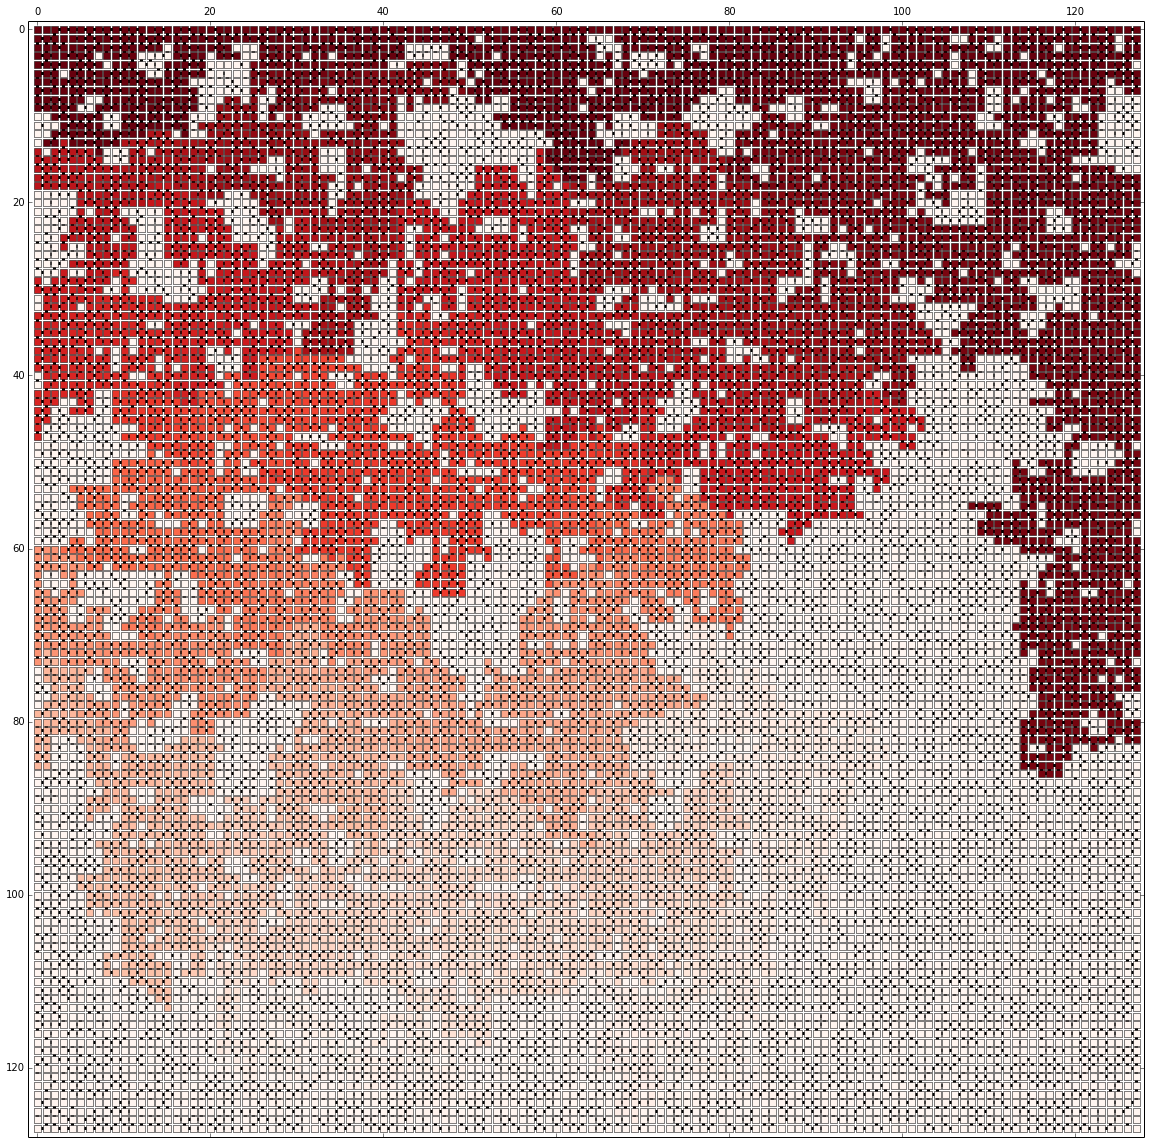

In [294]:
Rnet.solve_voltages('spsolve')
fig, ax = plt.subplots(figsize=(15,15))
Rnet.display_grid(ax, (L, L), 'voltage', nodesize=6)

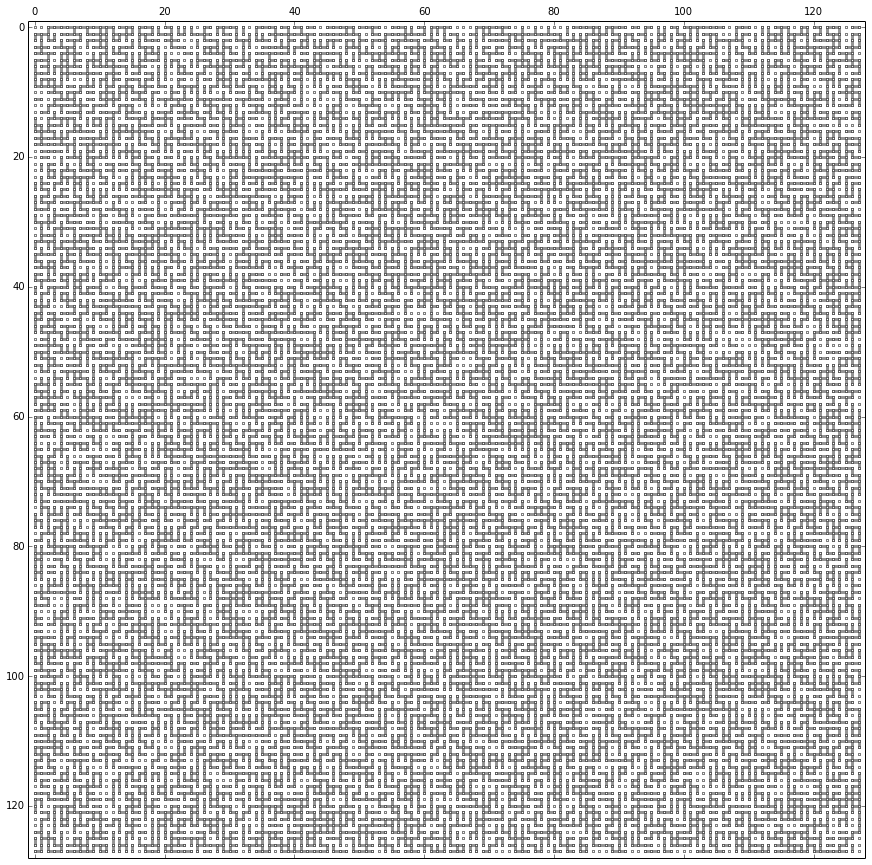

In [295]:
fig, ax = plt.subplots(figsize=(15,15))
Rnet.display_grid(ax, (L, L), 'conductance', nodesize=2, colormin=0, colormax=2)

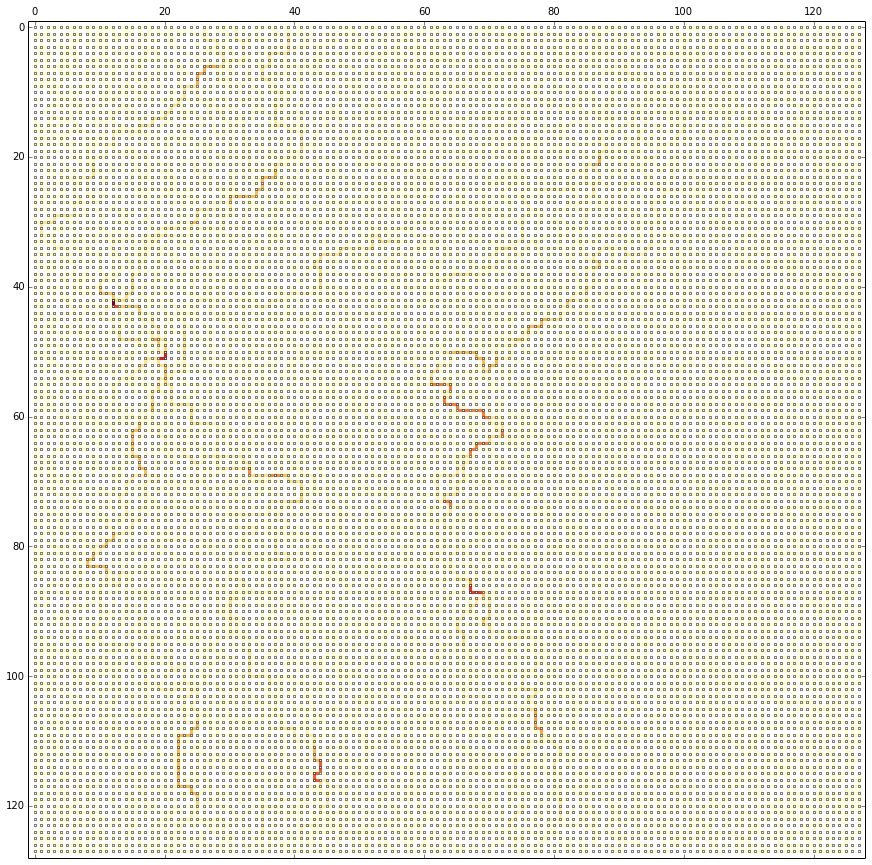

In [296]:
fig, ax = plt.subplots(figsize=(15, 15))
Rnet.display_grid(ax, (L, L), 'power', nodesize=2)

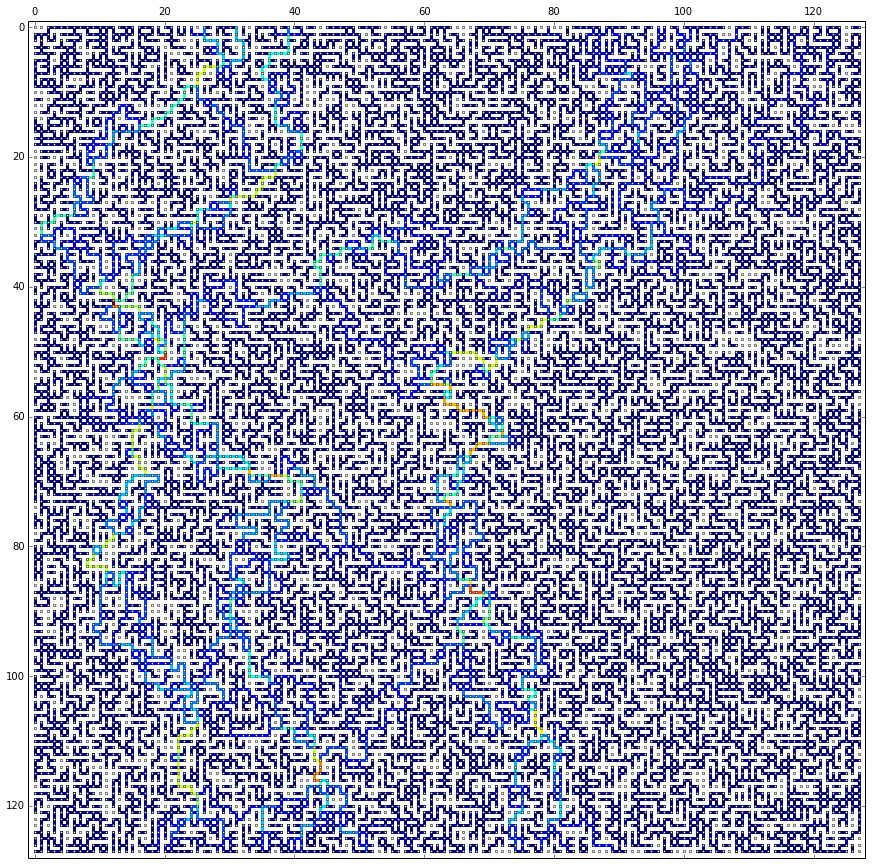

In [297]:
fig, ax = plt.subplots(figsize=(15,15))
Rnet.display_grid(ax, (L, L), 'voltage_drop', nodesize=2)

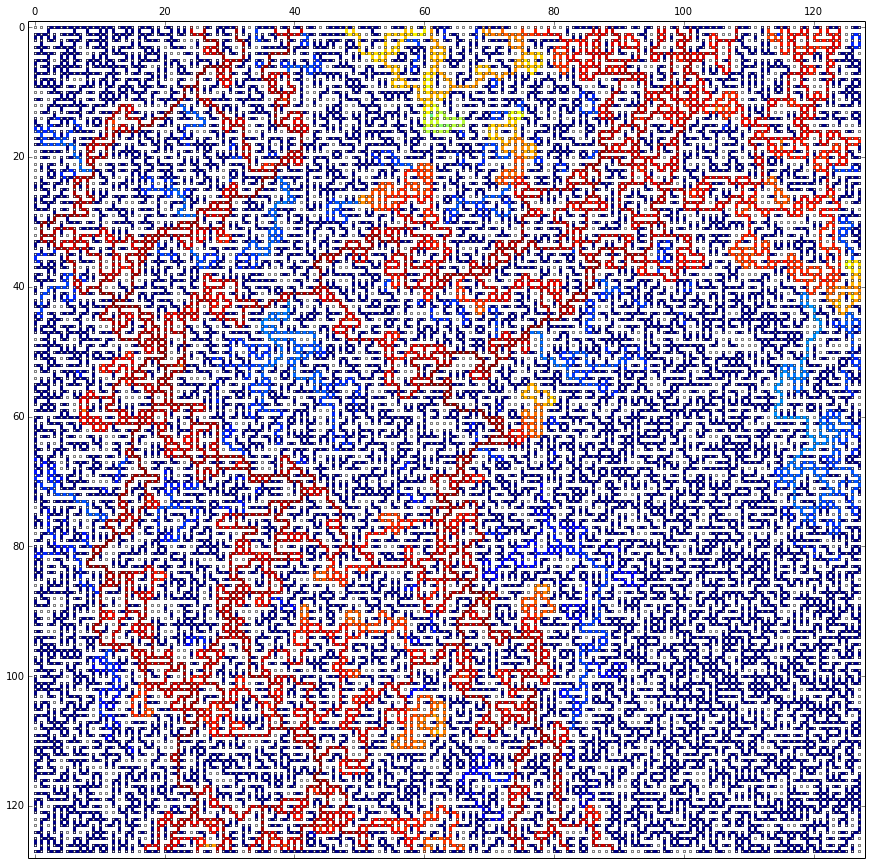

In [298]:
fig, ax = plt.subplots(figsize=(15, 15))
Rnet.display_grid(ax, (L, L), 'log_voltage_drop', nodesize=2)

## Obsolete

In [35]:
class ResistorLattice2DCubic(ResistorNetworkCC):
    
    def __init__(self, G, external_voltage, lattice_shape):
        ResistorNetworkCC.__init__(self, G, external_voltage)
        self.lattice_shape = lattice_shape
        if self.nodes != (self.lattice_shape[0] * self.lattice_shape[1]):
            print "Number of nodes is not consistent with the shape of the lattice!"
    
    def display_grid(self, ax, lattice_shape, display_variable, nodesize=5, bondwidth=3, colormin=None, colormax=None):
        """
        This method displays a 2D cubic resistor lattice of shape lattice_shape = (y, x).  The variables
        that may be displayed are:
        
            'voltage'
            'power'
            'conductance'
            
        Nodes are indexed across rows such that the first row has nodes 0 through x-1.  This is because I typically
        like to set up networks with a vertical bus bar architecture and it makes setting the nodes as simple as possible.
        """ 
        def node2xy(node_idx):
            """
            returns the x and y coordinates of a node index in our grid supposing that the 0,0 point is in the upper left
            and the positive y-axis points down
            """
            return node_idx % lattice_shape[1], int(node_idx / lattice_shape[1]) 
        
        # Pull nonzero values to plot bonds
        rows, cols = sparse.triu(self.G).nonzero()
        
        
        # Set up colormap normalization
        
        if colormin != None:
            norm = plt.Normalize(vmin=colormin, vmax=colormax)
        elif display_variable == 'voltage':
            norm = plt.Normalize()
            norm.autoscale(self.voltages)
        elif display_variable == 'power':
            power = self.power()
            norm = plt.Normalize(vmin=power.min(), vmax=power.max())
        elif display_variable == 'conductance':
            conductances = self.G[rows, cols]
            norm = plt.Normalize(vmin=conductances.min(), vmax=conductances.max())
        
        if display_variable == 'voltage':
            colormap = plt.get_cmap('Reds')
        elif display_variable == 'power':
            colormap = plt.get_cmap('YlOrRd')
        elif display_variable == 'conductance':
            colormap = plt.get_cmap('coolwarm')
        else:
            print 'Invalid display variable %s' % display_variable
        
        
            
        # Draw the bonds between nodes
        for node_i, node_j in itertools.izip(rows, cols):
            x_i, y_i = node2xy(node_i)
            x_j, y_j = node2xy(node_j)
            if display_variable == 'voltage':
                ax.plot([x_i, x_j], [y_i, y_j], 'k', lw = bondwidth)
            elif display_variable == 'power':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(power[node_i, node_j])), lw=bondwidth)
            elif display_variable == 'conductance':
                ax.plot([x_i, x_j], [y_i, y_j], color=colormap(norm(self.G[node_i, node_j])), lw=bondwidth)
        
        # Now draw the nodes
        if display_variable == 'voltage':
            for node, volt in enumerate(self.voltages):
                x, y = node2xy(node)
                ax.plot(x, y, 's', markersize=nodesize, color=colormap(norm(volt)))
        elif display_variable == 'power' or display_variable == 'conductance':
            for node in range(self.nodes):
                x, y = node2xy(node)
                ax.plot(x, y, 'ws', markersize=nodesize)
        
        # And finally set the axes to be just outside the grid spacing and invert the y_axis
        ax.set_xlim( -1, lattice_shape[1])
        ax.set_ylim( -1, lattice_shape[0])
        ax.invert_yaxis()
        ax.xaxis.set_tick_params(labelbottom='off', labeltop='on')